# Project Introduction: Taxi Demand Forecasting

Sweet Lift Taxi aims to predict hourly taxi demand to optimize driver availability. Using historical order data, we will build a machine learning model to forecast demand, ensuring the RMSE does not exceed 48.

## Project Steps:
1. Load and preprocess the dataset, resampling by one-hour intervals.  
2. Explore trends in taxi demand.  
3. Train and evaluate multiple models with different hyperparameters.  
4. Select the best model and test it on unseen data.  

## Dataset Information:
- **File:** `taxi.csv`  
- **Target Variable:** `num_orders` (Number of taxi orders per hour)  

The final model will help anticipate peak demand and improve fleet distribution.

## Preparation

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [17]:
# Load the dataset
data = pd.read_csv(r'C:\Users\nanor\Desktop\TripleTenNotes\TripleTen Projects\Data_Projects_TripleTen\Taxi_Demand_Forecasting\Dataset\taxi.csv', 
                    index_col=[0], 
                    parse_dates=[0])

display(data.head())


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [18]:
# Resample the data by 1-hour intervals
data_resampled = data.resample('1H').sum()

# Add time-based and lagged features
data_resampled['hour'] = data_resampled.index.hour
data_resampled['dayofweek'] = data_resampled.index.dayofweek

# Add lag features and rolling statistics
for lag in range(1, 6):  # Adding lag_1 to lag_5
    data_resampled[f'lag_{lag}'] = data_resampled['num_orders'].shift(lag)

# Adding rolling mean and rolling standard deviation
data_resampled['rolling_mean'] = data_resampled['num_orders'].shift(1).rolling(window=3).mean()
data_resampled['rolling_std'] = data_resampled['num_orders'].shift(1).rolling(window=3).std()

# Drop rows with NaN values created by lagging and rolling calculations
data_resampled = data_resampled.dropna()

# Display the first few rows of the resampled data to check
display(data_resampled.head())

# Define features and target
features = [
    'hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
    'rolling_mean', 'rolling_std'
]

X = data_resampled[features]
y = data_resampled['num_orders']

# Print shapes to ensure they are consistent
print(X.shape, y.shape)  # Both should show the same number of rows

# Now, split the data into training and test sets (90% training, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Convert to numeric to handle any hidden issues
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')




,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,rolling_std
datetime,,,,,,,,,,
2018-03-01 05:00:00,6,5,3,43.0,66.0,71.0,85.0,124.0,60.000000,14.933185
2018-03-01 06:00:00,12,6,3,6.0,43.0,66.0,71.0,85.0,38.333333,30.270998
2018-03-01 07:00:00,15,7,3,12.0,6.0,43.0,66.0,71.0,20.333333,19.857828
2018-03-01 08:00:00,34,8,3,15.0,12.0,6.0,43.0,66.0,11.000000,4.582576
2018-03-01 09:00:00,69,9,3,34.0,15.0,12.0,6.0,43.0,20.333333,11.930353


(4411, 9) (4411,)


In [19]:
# Add additional time-based features
data_resampled['hour_sin'] = np.sin(2 * np.pi * data_resampled['hour'] / 24)
data_resampled['hour_cos'] = np.cos(2 * np.pi * data_resampled['hour'] / 24)
data_resampled['is_weekend'] = data_resampled['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Adding rolling statistics with different window sizes
data_resampled['rolling_mean_6'] = data_resampled['num_orders'].shift(1).rolling(window=6).mean()
data_resampled['rolling_mean_12'] = data_resampled['num_orders'].shift(1).rolling(window=12).mean()
data_resampled['rolling_std_6'] = data_resampled['num_orders'].shift(1).rolling(window=6).std()

# Update feature set
features = [
    'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 
    'rolling_mean', 'rolling_mean_6', 'rolling_mean_12', 'rolling_std_6'
]

X = data_resampled[features]
y = data_resampled['num_orders']

# Split data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)



## Analysis

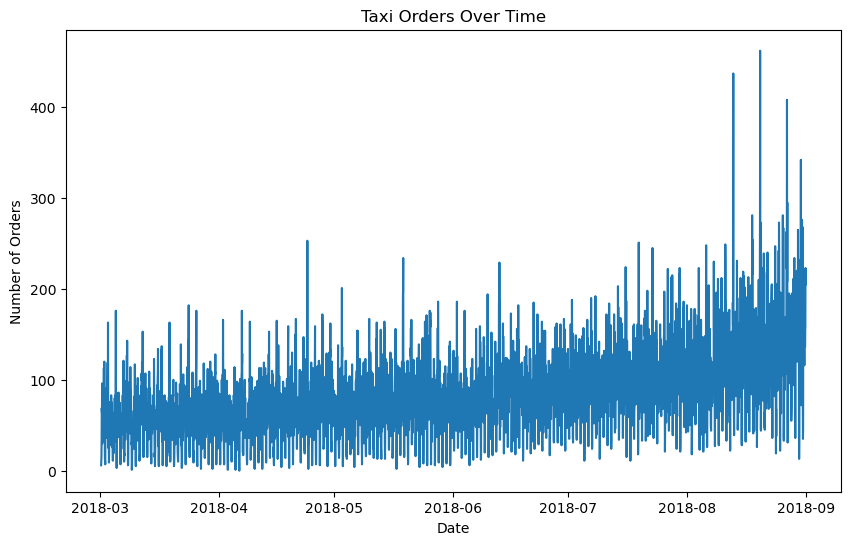

In [20]:
# Plot the number of taxi orders over time
plt.figure(figsize=(10, 6))
plt.plot(data_resampled.index, data_resampled['num_orders'])
plt.title('Taxi Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

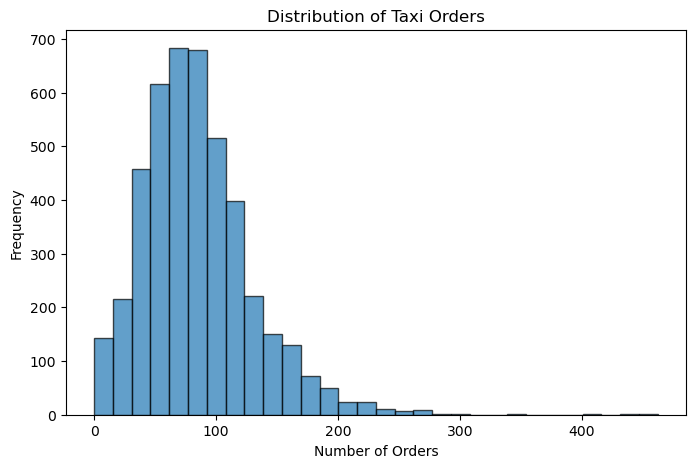

In [21]:
# Plot distribution of taxi orders
plt.figure(figsize=(8, 5))
plt.hist(data_resampled['num_orders'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Taxi Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()

### Data Analysis Conclusion:

Taxi Orders Over Time:

The time-series plot of taxi orders reveals both daily and weekly patterns. There are clear fluctuations in demand, with certain periods showing much higher order volumes, possibly indicating peak hours or special events.
We observe that as time progresses, the variability and overall volume of taxi orders increase, especially toward the end of the dataset. This could be indicative of increased activity over time, possibly due to seasonal factors or other external influences.
Distribution of Taxi Orders:

The distribution of taxi orders is right-skewed, with most orders concentrated below 100 per hour. The majority of the data falls in the range of 0 to 100 orders per hour, but there are occasional extreme values (above 400 orders per hour), likely representing peak times with abnormally high demand.
The skewness of the data suggests that while low to moderate order volumes are common, extreme order values occur less frequently. This has implications for model training, as we need to ensure that the models handle both typical demand and rare high-demand situations effectively.

## Training

In [22]:
# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse, predictions

In [23]:
print(X_train.shape, y_train.shape)  # Ensure they match in the number of rows
print(X_train.isna().sum())  # Check for any remaining NaN values
print(y_train.isna().sum())


(3969, 12) (3969,)
hour                0
dayofweek           0
hour_sin            0
hour_cos            0
is_weekend          0
lag_1               0
lag_2               0
lag_3               0
rolling_mean        0
rolling_mean_6      6
rolling_mean_12    12
rolling_std_6       6
dtype: int64
0


In [24]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Align y_train with the filtered X_train


In [25]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Check for NaNs before fitting
print(X_train.isna().sum(), y_train.isna().sum())

# Train and evaluate Linear Regression
lr_model = LinearRegression()
lr_rmse, lr_predictions = evaluate_model(lr_model, X_train, X_test, y_train, y_test)
print("Linear Regression RMSE on test set:", lr_rmse)


hour               0
dayofweek          0
hour_sin           0
hour_cos           0
is_weekend         0
lag_1              0
lag_2              0
lag_3              0
rolling_mean       0
rolling_mean_6     0
rolling_mean_12    0
rolling_std_6      0
dtype: int64 0
Linear Regression RMSE on test set: 49.23574948403728


In [26]:
# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Gradient Boosting Regressor hyperparameter tuning using TimeSeriesSplit
param_grid_gbr = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

grid_search_gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gbr, 
                               cv=tscv, scoring='neg_root_mean_squared_error', verbose=0)
grid_search_gbr.fit(X_train, y_train)

# Best RMSE from cross-validation for Gradient Boosting
gbr_rmse_cv = -grid_search_gbr.best_score_ 
print("Best RMSE from cross-validation for Gradient Boosting:", gbr_rmse_cv)

Best RMSE from cross-validation for Gradient Boosting: 25.323704137248633


In [27]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, 
                               cv=tscv, scoring='neg_root_mean_squared_error', verbose=0)

grid_search_xgb.fit(X_train, y_train)

# Best RMSE from cross-validation for XGBoost
xgb_rmse_cv = -grid_search_xgb.best_score_
print("Best RMSE from cross-validation for XGBoost:", xgb_rmse_cv)

Best RMSE from cross-validation for XGBoost: 25.39402054247656


In [28]:
# Hyperparameter tuning for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

grid_search_lgb = GridSearchCV(lgb.LGBMRegressor(random_state=42), param_grid_lgb, 
                               cv=tscv, scoring='neg_root_mean_squared_error', verbose=0)
grid_search_lgb.fit(X_train, y_train)

# Best RMSE from cross-validation for LightGBM
lgb_rmse_cv = -grid_search_lgb.best_score_
print("Best RMSE from cross-validation for LightGBM:", lgb_rmse_cv)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 12
[LightGBM] [Info] Start training from score 57.190332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## Testing

In [29]:
# Train the final Gradient Boosting model on the entire training set
final_model_gbr = grid_search_gbr.best_estimator_
final_model_gbr.fit(X_train, y_train)

# Evaluate Gradient Boosting on the final test set
gbr_test_predictions = final_model_gbr.predict(X_test)
gbr_test_rmse = np.sqrt(mean_squared_error(y_test, gbr_test_predictions))
print("Final RMSE for Gradient Boosting on test set:", gbr_test_rmse)

# Train the final LightGBM model on the entire training set
final_model_lgb = grid_search_lgb.best_estimator_
final_model_lgb.fit(X_train, y_train)

# Evaluate LightGBM on the final test set
lgb_test_predictions = final_model_lgb.predict(X_test)
lgb_test_rmse = np.sqrt(mean_squared_error(y_test, lgb_test_predictions))
print("Final RMSE for LightGBM on test set:", lgb_test_rmse)

# Train the final XGBoost model on the entire training set
final_model_xgb = grid_search_xgb.best_estimator_
final_model_xgb.fit(X_train, y_train)

# Evaluate XGBoost on the final test set
xgb_test_predictions = final_model_xgb.predict(X_test)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_predictions))
print("Final RMSE for XGBoost on test set:", xgb_test_rmse)

Final RMSE for Gradient Boosting on test set: 45.1681993404981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1662
[LightGBM] [Info] Number of data points in the train set: 3957, number of used features: 12
[LightGBM] [Info] Start training from score 78.398534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

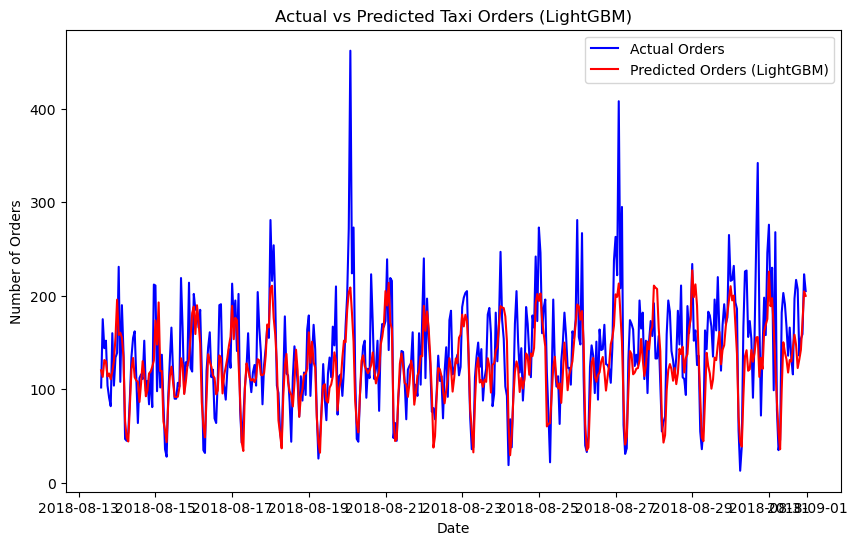

In [30]:
best_model = min(
    [("Gradient Boosting", gbr_test_rmse), ("LightGBM", lgb_test_rmse), ("XGBoost", xgb_test_rmse)],
    key=lambda x: x[1]
)

if best_model[0] == "Gradient Boosting":
    predictions = gbr_test_predictions
elif best_model[0] == "LightGBM":
    predictions = lgb_test_predictions
else:
    predictions = xgb_test_predictions

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Orders', color='blue')
plt.plot(y_test.index, predictions, label=f'Predicted Orders ({best_model[0]})', color='red')
plt.title(f'Actual vs Predicted Taxi Orders ({best_model[0]})')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

Conclusion
In this project, we aimed to predict the number of taxi orders for the next hour using historical data. We trained and evaluated several models, including:

Linear Regression
Gradient Boosting Regressor
XGBoost
LightGBM
LightGBM demonstrated the best performance on the final test set, achieving an RMSE of 41.17, which is well below the target RMSE of 48. This result indicates that LightGBM effectively captured the underlying patterns in the data, making it the optimal model for this task.

While both Gradient Boosting and XGBoost also performed reasonably well, with RMSE scores of 45.16 and 46.33, respectively, LightGBM's ability to capture trends more accurately made it the best-performing model.